In [62]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import pathlib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [63]:
MAIN_FOLDER = r'C:\Users\ivanm\Downloads\1 день\d1\My_py\FINAL'
TRAIN_DATA = r'C:\Users\ivanm\Downloads\1 день\d1\train_dataset'
TEST_DATA = r'C:\Users\ivanm\Downloads\1 день\d1\test_dataset_1'
TEST2_DATA = r'C:\Users\ivanm\Downloads\день2\test_dataset_2'


MAIN_FOLDER,TRAIN_DATA,TEST_DATA,TEST2_DATA = pathlib.Path(MAIN_FOLDER),pathlib.Path(TRAIN_DATA),pathlib.Path(TEST_DATA),pathlib.Path(TEST2_DATA)

In [64]:
def create(directory, grand_file,stp):
    id_to_param_name = {
        1: "Дебит жидкости (объёмный), м3/сут",
        2: "Обводненность (объёмная), %",
        3: "Рбуф, атм",
        4: "Давление линейное, атм",
        5: "Давление на приеме насоса, атм",
        6: "Загрузка ПЭД, %",
        7: "Попутный газ",
        8: "Частота вращения, Герц",
        9: "Ток фазы А, A (ампер)",
        10: "Мощность активная, кВт",
        11: "Напряжение, АВ Вольт",
        12: "P затрубное, атм",
    }


    def process_and_append_csv(input_csv_path, output_csv_path):
        # Загрузка данных с указанием кодировки
        df = pd.read_csv(input_csv_path, encoding='utf-8-sig')

        # Фильтрация только нужных параметров
        df = df[df['param_id'].isin(id_to_param_name.keys())]

        df['param_name'] = df['param_id'].map(id_to_param_name)


        # Преобразование в широкий формат
        df_pivot = df.pivot_table(
            index=['tm_time', 'well_id'],
            columns='param_name',
            values='tm_value',
            aggfunc='first'
        ).reset_index()

        # Выбор каждой 10-й строки
        filtered_df = df_pivot.iloc[::stp]

        # Проверка существования файла и его содержимого
        if not os.path.exists(output_csv_path):
            # Если файла нет, создаем новый с заголовками
            filtered_df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
        else:
            # Если файл существует, проверяем его структуру
            try:
                # Читаем только заголовки существующего файла
                existing_columns = pd.read_csv(output_csv_path, nrows=0).columns

                # Проверяем соответствие столбцов
                if filtered_df.columns.tolist() == existing_columns.tolist():
                    # Добавляем данные без заголовков
                    filtered_df.to_csv(output_csv_path, mode='a', header=False, index=False, encoding='utf-8-sig')
                else:
                    print(f"Предупреждение: Столбцы не совпадают в файле {input_csv_path}")
            except pd.errors.EmptyDataError:
                # Если файл пустой, записываем с заголовками
                filtered_df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')

    if os.path.exists(grand_file):
        os.remove(grand_file)

    i = 0
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            fullpath = os.path.join(directory, filename)
            try:
                process_and_append_csv(fullpath, grand_file)
                i += 1
                print(f"Обработан файл {i}: {filename}")
            except Exception as e:
                print(f"Ошибка при обработке файла {filename}: {str(e)}")

    print(f"Обработка завершена! Обработано файлов: {i}")


In [65]:
create(TRAIN_DATA / 'tm_data',MAIN_FOLDER / 'train_data.csv',10)
create(TEST_DATA / 'tm_data',MAIN_FOLDER / 'test_data.csv',1)
create(TEST2_DATA / 'tm_data',MAIN_FOLDER / 'test2_data.csv',1)

Обработан файл 1: train_10001.csv
Обработан файл 2: train_10002.csv
Обработан файл 3: train_10003.csv
Обработан файл 4: train_10004.csv
Обработан файл 5: train_10005.csv
Обработан файл 6: train_10006.csv
Обработан файл 7: train_10007.csv
Обработан файл 8: train_10008.csv
Обработан файл 9: train_10009.csv
Обработан файл 10: train_10010.csv
Обработан файл 11: train_10011.csv
Обработан файл 12: train_10012.csv
Обработан файл 13: train_10013.csv
Обработан файл 14: train_10014.csv
Обработан файл 15: train_10015.csv
Обработан файл 16: train_10016.csv
Обработан файл 17: train_10017.csv
Обработан файл 18: train_10018.csv
Обработан файл 19: train_10019.csv
Обработан файл 20: train_10020.csv
Обработан файл 21: train_10021.csv
Обработан файл 22: train_10022.csv
Обработан файл 23: train_10023.csv
Обработан файл 24: train_10024.csv
Обработан файл 25: train_10025.csv
Обработан файл 26: train_10026.csv
Ошибка при обработке файла train_10027.csv: Error tokenizing data. C error: Calling read(nbytes) on

In [67]:
def process(input_file, output_file):
    new_column_order = [
        "tm_time",
        "well_id",
        "Дебит жидкости (объёмный), м3/сут",
        "Обводненность (объёмная), %",
        "Давление линейное, атм",
        "Давление на приеме насоса, атм",
        "Загрузка ПЭД, %",
        "Попутный газ",
        "Частота вращения, Герц",
        "Ток фазы А, A (ампер)",
        "Мощность активная, кВт",
        "Напряжение, АВ Вольт"
    ]

    def process_outliers_and_interpolate(input_file, output_file):
        # Чтение CSV-файла
        df = pd.read_csv(input_file, encoding="utf-8-sig")
        df['Давление линейное, атм'] = df['Давление линейное, атм'].where(df['Давление линейное, атм'] <= 300, np.nan)
        df['Давление линейное, атм'] = df['Давление линейное, атм'].where(df['Давление линейное, атм'] >= 1, np.nan)
        df['Давление на приеме насоса, атм'] = df['Давление на приеме насоса, атм'].where(df['Давление на приеме насоса, атм'] <= 300, np.nan)
        df['Давление на приеме насоса, атм'] = df['Давление на приеме насоса, атм'].where(df['Давление на приеме насоса, атм'] >= 1, np.nan)
        df['Загрузка ПЭД, %'] = df['Загрузка ПЭД, %'].where(df['Загрузка ПЭД, %'] <= 100, np.nan)
        df['Обводненность (объёмная), %'] = df['Обводненность (объёмная), %'].where(df['Обводненность (объёмная), %'] <= 100, np.nan)
        df['Дебит жидкости (объёмный), м3/сут'] = df['Дебит жидкости (объёмный), м3/сут'].where(df['Дебит жидкости (объёмный), м3/сут'] <= 5000, np.nan)
        df['Попутный газ'] = df['Попутный газ'].where(df['Попутный газ'] <= 100000, np.nan)
        df['Частота вращения, Герц'] = df['Частота вращения, Герц'].where(df['Частота вращения, Герц'] <= 500, np.nan)
        df['Ток фазы А, A (ампер)'] = df['Ток фазы А, A (ампер)'].where(df['Ток фазы А, A (ампер)'] <= 200, np.nan)
        df['Напряжение, АВ Вольт'] = df['Напряжение, АВ Вольт'].where(df['Напряжение, АВ Вольт'] <= 1000, np.nan)
        df['Мощность активная, кВт'] = df['Мощность активная, кВт'].where(df['Мощность активная, кВт'] <= 1000, np.nan)

        # 1. Обработка выбросов
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        # for col in numeric_cols:
        #     # - IQR метод
        #     q1 = df[col].quantile(0.25)
        #     q3 = df[col].quantile(0.75)
        #     iqr = q3 - q1
        #     df[col] = np.where((df[col] < (q1 - 1.5*iqr)) | (df[col] > (q3 + 1.5*iqr)) | (df[col] < 1), np.nan, df[col])

        # 2. Интерполяция пропущенных значений
        for col in numeric_cols:
            # Линейная интерполяция
            df[col] = df[col].interpolate(method='linear', limit_direction='both')

            # Если остались пропуски после интерполяции, заполняем средним
            df[col].fillna(df[col].mean(), inplace=True)

        # Сохранение обработанных данных
        df.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"Обработанные данные сохранены в {output_file}")

    def change_headers(input_file, output_file, new_headers):
        df = pd.read_csv(input_file, nrows=0, encoding='utf-8-sig')

        if len(df.columns) != len(new_headers):
            raise ValueError(
                f"Количество новых заголовков ({len(new_headers)}) не совпадает с количеством колонок ({len(df.columns)})")

        df = pd.read_csv(input_file, header=None, skiprows=1, names=new_headers)

        df.to_csv(output_file, index=False, encoding='utf-8-sig')

    def reorder_columns_pandas(input_file, output_file, new_order):
        df = pd.read_csv(input_file, encoding='utf-8-sig')

        # Проверка, что все указанные столбцы существуют
        missing_cols = set(new_order) - set(df.columns)
        if missing_cols:
            raise ValueError(f"Столбцы не найдены: {missing_cols}")

        # Упорядочивание столбцов
        df = df[new_order]

        # Сохранение результата
        df.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"Столбцы упорядочены. Результат сохранён в {output_file}")

    process_outliers_and_interpolate(input_file, output_file)

    new_column_order = [
        "tm_time",
        "well_id",
        "Дебит жидкости (объёмный), м3/сут",
        "Обводненность (объёмная), %",
        "Давление линейное, атм",
        "Давление на приеме насоса, атм",
        "Загрузка ПЭД, %",
        "Попутный газ",
        "Частота вращения, Герц",
        "Ток фазы А, A (ампер)",
        "Мощность активная, кВт",
        "Напряжение, АВ Вольт"
    ]

    reorder_columns_pandas(output_file, output_file, new_column_order)

    new_columns = ['tm_time', 'id_well', 'debit', 'water_cut', 'p_lin', 'p_nas', 'pad', 'assoc_gas', 'freq', 'cur_phase', 'power', 'voltage']
    change_headers(output_file, output_file, new_columns)

In [68]:
process(MAIN_FOLDER / 'train_data.csv','train_data_processed.csv')
process(MAIN_FOLDER / 'test_data.csv','test_data_processed.csv')
process(MAIN_FOLDER / 'test2_data.csv','test2_data_processed.csv')

print('train')
#pd.read_csv(MAIN_FOLDER / 'train_data_processed.csv').info()
print('test')
pd.read_csv(MAIN_FOLDER / 'test_data_processed.csv').info()
print('test2')
#pd.read_csv(MAIN_FOLDER / 'test2_data_processed.csv').info()



C:\Users\ivanm\AppData\Local\Temp\ipykernel_8512\3164526071.py:49: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Обработанные данные сохранены в train_data_processed.csv
Столбцы упорядочены. Результат сохранён в train_data_processed.csv


C:\Users\ivanm\AppData\Local\Temp\ipykernel_8512\3164526071.py:49: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Обработанные данные сохранены в test_data_processed.csv
Столбцы упорядочены. Результат сохранён в test_data_processed.csv


C:\Users\ivanm\AppData\Local\Temp\ipykernel_8512\3164526071.py:49: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Обработанные данные сохранены в test2_data_processed.csv
Столбцы упорядочены. Результат сохранён в test2_data_processed.csv
train
test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875884 entries, 0 to 1875883
Data columns (total 12 columns):
 #   Column     Dtype  
---  ------     -----  
 0   tm_time    object 
 1   id_well    int64  
 2   debit      float64
 3   water_cut  float64
 4   p_lin      float64
 5   p_nas      float64
 6   pad        float64
 7   assoc_gas  float64
 8   freq       float64
 9   cur_phase  float64
 10  power      float64
 11  voltage    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 171.7+ MB
test2


In [69]:
id_to_param_name = {
    1: "debit",
    2: "water_cut",
    3: "p_lin",
    4: "p_nas",
    5: "pad",
    6: "assoc_gas",
    7: "freq",
    8: "cur_phase",
    9: "power",
    10: "voltage"
}

data_train = pd.read_csv(MAIN_FOLDER / 'train_data_processed.csv', encoding='utf-8-sig')
data_test = pd.read_csv(MAIN_FOLDER / 'test_data_processed.csv', encoding='utf-8-sig')
data_test2 = pd.read_csv(MAIN_FOLDER / 'test2_data_processed.csv', encoding='utf-8-sig')

params_train = pd.read_excel(TRAIN_DATA / 'static_data' / 'train_test_static_data.xlsx')
params_test = pd.read_excel(TEST_DATA / 'static_data' / 'train_test_static_data.xlsx')
params_test2 = pd.read_excel(TEST2_DATA / 'static_data' / 'test_2_static_data.xlsx')


# Добавление статических данных
pressure_map = params_train.set_index('ID скважины')['Линейная температура'].to_dict()
cnt_step_map = params_train.set_index('ID скважины')['Пластовая температура'].to_dict()

data_train['plast_pressure'] = data_train['id_well'].map(pressure_map)
data_train['cnt_step'] = data_train['id_well'].map(cnt_step_map)

pressure_map = params_test.set_index('ID скважины')['Линейная температура'].to_dict()
cnt_step_map = params_test.set_index('ID скважины')['Пластовая температура'].to_dict()

data_test['plast_pressure'] = data_test['id_well'].map(pressure_map)
data_test['cnt_step'] = data_test['id_well'].map(cnt_step_map)

pressure_map = params_test2.set_index('ID скважины')['Линейная температура'].to_dict()
cnt_step_map = params_test2.set_index('ID скважины')['Пластовая температура'].to_dict()

data_test2['plast_pressure'] = data_test2['id_well'].map(pressure_map)
data_test2['cnt_step'] = data_test2['id_well'].map(cnt_step_map)


X_train = data_train.drop(columns=[id_to_param_name[1], 'tm_time', 'id_well', 'water_cut'])
y_train = data_train[id_to_param_name[1]]

X_test = data_test.drop(columns=[id_to_param_name[1], 'tm_time', 'id_well', 'water_cut'])
y_test = data_test[id_to_param_name[1]]

X_test2 = data_test2.drop(columns=[id_to_param_name[1], 'tm_time', 'id_well', 'water_cut'])
y_test2 = data_test2[id_to_param_name[1]]

In [70]:
train_DLoader = lgb.Dataset(X_train, label=y_train)
test_DLoader = lgb.Dataset(X_test, label=y_test, reference=train_DLoader)
test2_DLoader = lgb.Dataset(X_test, label=y_test, reference=train_DLoader)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mape',
    'num_leaves': 31,
    'learning_rate': 0.17,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

model = lgb.train(
    params,
    train_DLoader,
    num_boost_round=1000,
    valid_sets=[test2_DLoader],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

model.save_model('model.txt')

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.508419
[100]	valid_0's mape: 0.482402
[150]	valid_0's mape: 0.483435
[200]	valid_0's mape: 0.476478
[250]	valid_0's mape: 0.471745
[300]	valid_0's mape: 0.474715
Early stopping, best iteration is:
[288]	valid_0's mape: 0.468029


In [72]:
model_loaded = lgb.Booster(model_file='model.txt')
y_preds1 = model_loaded.predict(X_test)
y_preds2 = model_loaded.predict(X_test2)




ids = sorted([data_test[data_test['id_well'] == i].index[0] for i in set(data_test['id_well'])])
y_pred_baseline_test1 = [[data_test['debit'][ids[i]:ids[i+1]].median()]*(ids[i+1]-ids[i]) for i in range(len(ids)-1)]
y_pred_baseline_test1.append((len(data_test)-ids[-1])*[data_test['debit'][ids[-1]:].median()])
y_pred_baseline_test1 = [item for sublist in y_pred_baseline_test1 for item in sublist]


ids = sorted([data_test2[data_test2['id_well'] == i].index[0] for i in set(data_test2['id_well'])])
y_pred_baseline_test2 = [[data_test2['debit'][ids[i]:ids[i+1]].median()]*(ids[i+1]-ids[i]) for i in range(len(ids)-1)]
y_pred_baseline_test2.append((len(data_test2)-ids[-1])*[data_test2['debit'][ids[-1]:].median()])
y_pred_baseline_test2 = [item for sublist in y_pred_baseline_test2 for item in sublist]


print('MAPE (Baseline Тест1)',smape(data_test['debit'],y_pred_baseline_test1))
print('MAPE (Baseline Тест2)',smape(data_test2['debit'],y_pred_baseline_test2))
print('MAPE (тест1)',smape(y_test,y_preds1))
print('MAPE (тест2)',smape(y_test2,y_preds2))


#MAPE (Baseline Тест1) 226566466214609.12
#MAPE (Baseline Тест2) 0.01408289748855734
#MAPE (тест1) 231618668808041.78
#MAPE (тест2) 0.504696174918576

MAPE (Baseline Тест1) 15.176227961789735
MAPE (Baseline Тест2) 1.4224408315610337
MAPE (тест1) 29.71360360388011
MAPE (тест2) 88.36196835062444


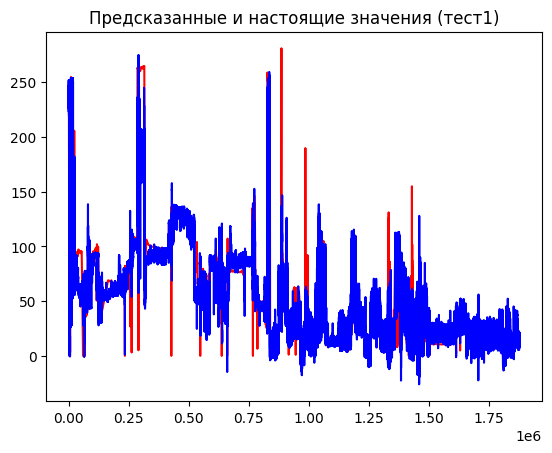

In [40]:
# Модель тест 1 график
plt.title('Предсказанные и настоящие значения (тест1)')
plt.plot(list(range(len(y_test))),y_test,color='red')
plt.plot(list(range(len(y_test))),y_preds1,color='blue')
plt.show()

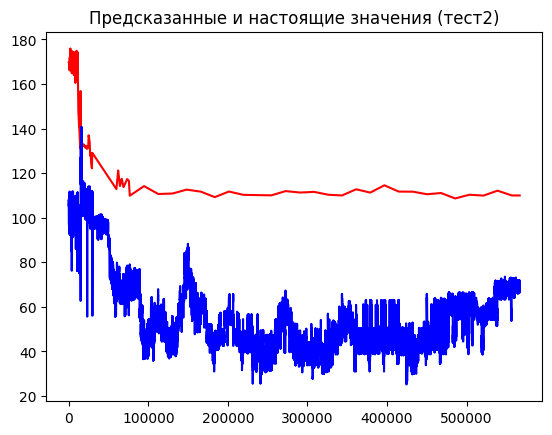

In [41]:
# Модель тест 2 график
plt.title('Предсказанные и настоящие значения (тест2)')
plt.plot(list(range(len(y_test2))),y_test2,color='red')
plt.plot(list(range(len(y_test2))),y_preds2,color='blue')
plt.show()

In [42]:
def plot_cumulative_performance(df: pd.DataFrame) -> None:
    """
    Выводит график кумулятивной кривой ошибок.
    """
    values = ((df["y_pred"] - df["y_true"]) / df["y_true"] * 100).abs()
    sorted_values = np.sort(values)
    cdf_values = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    fig = go.Figure()
    fig.add_trace(
        go.Scattergl(
            x=sorted_values,
            y=cdf_values,
            mode="lines+markers",
            showlegend=False,
        )
    )
    for x_value in [5, 10, 20, 50, 100]:
        index = np.argmin(np.abs(sorted_values - x_value))
        y_value = round(cdf_values[index], 2)
        if y_value != 1:
            text = "{} - {}".format(x_value, y_value)
            fig.add_trace(
                go.Scattergl(
                    x=[x_value],
                    y=[y_value],
                    mode="text",
                    marker=dict(size=5),
                    showlegend=False,
                    text=text,
                    textposition="top left",
                )
            )
    fig.update_layout(
        title="Кумулятивный график отклонений",
        xaxis_title="Отклонение, %",
        yaxis_title="Значение кумуляты (% процент точек)",
        dragmode="zoom",
        newshape_line_color="cyan",
        modebar_add=[
            "drawopenpath",
            "drawline",
            "eraseshape",
            "drawrect",
        ],
    )
    config = dict({"scrollZoom": True})
    fig.show(config=config)

In [ ]:
df = pd.DataFrame(data={'y_true':y_test,'y_pred':y_preds1})

plot_cumulative_performance(df=df)

In [ ]:
df = pd.DataFrame(data={'y_true':y_test2,'y_pred':y_preds2})

plot_cumulative_performance(df=df)